In [7]:
# Cell: Parse whitespace table and save to Excel (or CSV fallback)
import pandas as pd
from io import StringIO

text = """
species  support  precision   recall       f1
    Sma      300   0.177143 0.103333 0.130526
   CaAl      300   0.256098 0.210000 0.230769
    Lmo      300   0.972603 0.236667 0.380697
   CaTr      300   0.371901 0.450000 0.407240
    Cfr      300   0.651899 0.343333 0.449782
    Aba      300   0.623656 0.386667 0.477366
    Spn      300   0.644444 0.386667 0.483333
    Kox      300   0.663366 0.446667 0.533865
    Kpn      300   0.741176 0.420000 0.536170
    Eae      300   0.581994 0.603333 0.592471
""".strip("\n")

# Parse using whitespace as delimiter
df = pd.read_csv(StringIO(text), delim_whitespace=True)

# Tidy column names
rename = {"species":"Species","support":"Support","precision":"Precision","recall":"Recall","f1":"F1"}
df = df.rename(columns=rename)

# (Optional) keep original order; if you want alphabetical by Species, uncomment:
# df = df.sort_values("Species").reset_index(drop=True)

# Save to Excel if possible, else CSV
xlsx_path = "worst_species_table.xlsx"
csv_path  = "worst_species_table.csv"

try:
    import openpyxl
    df.to_excel(xlsx_path, index=False, sheet_name="table")
    print(f"Saved Excel to: {xlsx_path}")
except ImportError:
    df.to_csv(csv_path, index=False)
    print(f"openpyxl not installed; saved CSV instead: {csv_path}")

# Preview
print(df.to_string(index=False))


openpyxl not installed; saved CSV instead: worst_species_table.csv
Species  Support  Precision   Recall       F1
    Sma      300   0.177143 0.103333 0.130526
   CaAl      300   0.256098 0.210000 0.230769
    Lmo      300   0.972603 0.236667 0.380697
   CaTr      300   0.371901 0.450000 0.407240
    Cfr      300   0.651899 0.343333 0.449782
    Aba      300   0.623656 0.386667 0.477366
    Spn      300   0.644444 0.386667 0.483333
    Kox      300   0.663366 0.446667 0.533865
    Kpn      300   0.741176 0.420000 0.536170
    Eae      300   0.581994 0.603333 0.592471


C:\Users\Kra\AppData\Local\Temp\ipykernel_13004\1835571970.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(StringIO(text), delim_whitespace=True)


In [4]:
# Cell 1: Data Loading, Preprocessing, and Stratified Species-wise Split
import pandas as pd
import numpy as np
from collections import defaultdict

df = pd.read_csv(
    './data300.csv',
    dtype={'Sample': str, 'AB': str},
    low_memory=False,
)
df['Sample'] = df['Sample'].astype(str)

df['Group'] = (
    df['Group']
      .str.strip()
      .str.lower()
      .map({
        'neg': 'Neg',
        'gram‐negative': 'Neg',
        'gram-negative bacteria': 'Neg',
        'pos': 'Pos',
        'gram‐positive': 'Pos',
        'gram-positive bacteria': 'Pos',
        'yeast': 'Fungi',
        'fungi': 'Fungi',
      })
)
print("Normalized groups:", df['Group'].unique())

intensity_cols = df.columns[5:]
X_vals = df[intensity_cols].to_numpy(np.float32)
mins    = X_vals.min(axis=1, keepdims=True)
maxs    = X_vals.max(axis=1, keepdims=True)
rngs    = np.where(maxs - mins == 0, 1.0, maxs - mins)
X_norm  = (X_vals - mins) / rngs

species_labels  = df['ID'].astype(str).values
unique_species  = sorted(np.unique(species_labels))
label_to_idx    = {lab: i for i, lab in enumerate(unique_species)}
y_full          = np.array([label_to_idx[s] for s in species_labels],
                           dtype=np.int64)

df['sample_key'] = df['ID'].astype(str) + '_' + df['Sample'].astype(str)

# gather unique keys per species
species_to_keys = {
    sp: df.loc[df['ID'] == sp, 'sample_key'].unique().tolist()
    for sp in unique_species
}

# --- the DYNAMIC SPLIT loop ---
np.random.seed(11)
train_keys, val_keys, test_keys = [], [], []

for sp, keys in species_to_keys.items():
    np.random.shuffle(keys)
    if len(keys) == 1:
        train_keys.append(keys[0])
        continue

    test_keys.append(keys[0])
    rem = keys[1:]
    if len(rem) == 1:
        train_keys.append(rem[0])
        continue


    train_ratio = 0.85

    n_train = max(1, int(train_ratio * len(rem)))
    train_keys.extend(rem[:n_train])
    val_keys.extend(rem[n_train:])

# mask & slice    
train_mask = df['sample_key'].isin(train_keys)
val_mask   = df['sample_key'].isin(val_keys)
test_mask  = df['sample_key'].isin(test_keys)

X_train, y_train = X_norm[train_mask], y_full[train_mask]
X_val,   y_val   = X_norm[val_mask],   y_full[val_mask]
X_test,  y_test  = X_norm[test_mask],  y_full[test_mask]

# sanity check
total = len(df)
print(f"Total spectra: {total}")
print(f" Train: {X_train.shape[0]} ({X_train.shape[0]/total:.1%})")
print(f" Val:   {X_val.shape[0]} ({X_val.shape[0]/total:.1%})")
print(f" Test:  {X_test.shape[0]} ({X_test.shape[0]/total:.1%})\n")

import pandas as pd
train_counts = pd.Series(y_train).map(lambda i: unique_species[i]).value_counts()
val_counts   = pd.Series(y_val).map(lambda i: unique_species[i]).value_counts()
test_counts  = pd.Series(y_test).map(lambda i: unique_species[i]).value_counts()

print("Train set species counts:\n", train_counts, "\n")
print("Val   set species counts:\n", val_counts, "\n")
print("Test  set species counts:\n", test_counts)

# ---------- B) Split assignment exports ----------
# 1) Attach a Split label to every row using the masks from Cell 1
split = np.full(len(df), 'Unassigned', dtype=object)
split[train_mask.values] = 'Train'
split[val_mask.values]   = 'Val'
split[test_mask.values]  = 'Test'

df_split = df[['Group', 'ID', 'Sample', 'sample_key']].copy()
df_split['Split'] = split
df_split = df_split.rename(columns={'ID': 'Species'})
# Sort for readability: Group → Species → Sample
df_split = df_split.sort_values(['Group', 'Species', 'Sample'])

# 2) Per-species counts by split (pivot)
per_species_counts = (
    df_split.groupby(['Group', 'Species', 'Split'], as_index=False)
            .size()
            .pivot(index=['Group', 'Species'], columns='Split', values='size')
            .fillna(0).astype(int)
            .reset_index()
)

# Ensure all three split columns exist
for col in ['Train', 'Val', 'Test']:
    if col not in per_species_counts.columns:
        per_species_counts[col] = 0

# Add total column and sort
per_species_counts['Total'] = per_species_counts[['Train', 'Val', 'Test']].sum(axis=1)
per_species_counts = per_species_counts[['Group', 'Species', 'Train', 'Val', 'Test', 'Total']]
per_species_counts = per_species_counts.sort_values(['Group', 'Species'])

# 3) Optional: per-group aggregated counts
per_group_counts = (
    per_species_counts.groupby('Group', as_index=False)[['Train','Val','Test','Total']].sum()
    .sort_values('Group')
)

# 4) Save split outputs to Excel (multi-sheet) or CSVs
split_xlsx = "split_summary.xlsx"

try:
    import openpyxl
    with pd.ExcelWriter(split_xlsx, engine='openpyxl') as writer:
        df_split.to_excel(writer, index=False, sheet_name='rows')                 # row-level assignment
        per_species_counts.to_excel(writer, index=False, sheet_name='per_species')# counts per species
        per_group_counts.to_excel(writer, index=False, sheet_name='per_group')    # counts per group
    print(f"[OK] Saved split summary to: {split_xlsx}")
except ImportError:
    # CSV fallbacks
    df_split.to_csv("split_rows.csv", index=False)
    per_species_counts.to_csv("split_per_species.csv", index=False)
    per_group_counts.to_csv("split_per_group.csv", index=False)
    print("[OK] openpyxl not installed; saved split CSVs: split_rows.csv, split_per_species.csv, split_per_group.csv")

# Quick peeks
print("\nPer-species counts (head):")
print(per_species_counts.head(10).to_string(index=False))

print("\nPer-group counts:")
print(per_group_counts.to_string(index=False))

Normalized groups: ['Neg' 'Fungi' 'Pos']
Total spectra: 102600
 Train: 73800 (71.9%)
 Val:   18000 (17.5%)
 Test:  10800 (10.5%)

Train set species counts:
 Eco     4800
Api     3600
CaKr    3300
Kox     3300
Ano     3300
CaAl    3300
CaTr    3300
CaPa    3000
CrNe    3000
CaGu    3000
CaGl    3000
Efa     2700
Pae     1500
Kpn     1500
Aba     1500
Sma     1500
Cdi     1500
Mmo     1500
Stm     1500
Bce     1500
Sho     1500
Eae     1500
Cfr     1500
Ecl     1500
Sca     1500
Sau     1500
Efm     1500
Pmi     1500
Svi     1500
Shl     1500
Sep     1500
Sgc     1500
Bfg     1200
Spn     1200
Sal      900
Lmo      900
Name: count, dtype: int64 

Val   set species counts:
 Eco     900
Api     900
Ano     900
Kox     900
Sma     600
Pmi     600
Stm     600
CaGu    600
CaPa    600
CaAl    600
CaKr    600
Aba     600
CrNe    600
Cfr     600
Ecl     600
Eae     600
Efa     600
Mmo     600
CaTr    600
CaGl    600
Bce     300
Kpn     300
Bfg     300
Cdi     300
Efm     300
Sau     300
Lmo     

In [3]:
# Cell 2: Build species summary table and export to Excel
import pandas as pd

# 1) Define "strain" as a unique 'Sample' within each species (ID)
#    and "sample size" as the total number of spectra (rows).
summary = (
    df.assign(Group=df['Group'].fillna('Unknown'))
      .groupby(['Group', 'ID'], as_index=False)
      .agg(
          Strains=('Sample', 'nunique'),
          SampleSize=('ID', 'size')
      )
)

# 2) Sort species alphabetically within each group
summary = summary.sort_values(['Group', 'ID'], ascending=[True, True])

# 3) Rename columns to match your spec
summary = summary.rename(columns={
    'Group': 'Group',
    'ID': 'Species',
    'Strains': 'Number of Strains',
    'SampleSize': 'Sample Size'
})

# 4) Write to Excel
out_path = "species_summary.xlsx"
with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
    summary.to_excel(writer, index=False, sheet_name="summary")

print(f"Saved summary to {out_path}")
display(summary.head(10))


Saved summary to species_summary.xlsx


,Group,Species,Number of Strains,Sample Size
0,Fungi,CaAl,14,4200
1,Fungi,CaGl,13,3900
2,Fungi,CaGu,13,3900
3,Fungi,CaKr,14,4200
4,Fungi,CaPa,13,3900
5,Fungi,CaTr,14,4200
6,Fungi,CrNe,13,3900
7,Neg,Aba,8,2400
8,Neg,Ano,15,4500
9,Neg,Api,16,4800


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader

class RamanSpectraDataset(Dataset):
    def __init__(self, X, y, augment=False):
        """
        X: numpy array (N, seq_len)
        y: numpy array (N,)
        augment: bool, whether to apply on-the-fly spectral augmentation
        """
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
        self.augment = augment

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        spec = self.X[idx].clone()  # shape (seq_len,)

        if self.augment:
            # 1) Random Gaussian noise (σ=0.01)
            if torch.rand(1).item() < 0.5:
                spec += 0.01 * torch.randn_like(spec)
            # 2) Random shift ±5
            if torch.rand(1).item() < 0.5:
                shift = int(torch.randint(-5, 6, (1,)).item())
                spec = torch.roll(spec, shifts=shift, dims=0)
            # 3) Random scaling [0.9,1.1]
            if torch.rand(1).item() < 0.5:
                scale = float(torch.empty(1).uniform_(0.9,1.1))
                spec *= scale
            # 4) Small baseline drift
            if torch.rand(1).item() < 0.3:
                drift = torch.linspace(0, float(torch.randn(1)), spec.size(0))
                spec += drift
            spec = spec.clamp(0.0, 1.0)

        return spec, self.y[idx]

# Now build your loaders
batch_size = 256

# Training set with augmentation
train_ds = RamanSpectraDataset(X_train, y_train, augment=True)
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

# Validation & test without augmentation
val_ds = RamanSpectraDataset(X_val, y_val, augment=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                        num_workers=4, pin_memory=True)

test_ds = RamanSpectraDataset(X_test, y_test, augment=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                         num_workers=4, pin_memory=True)


In [3]:
import torch
import torch.nn as nn
import math
from torch.utils.data import Dataset, DataLoader

class RamanTransformerClassifier(nn.Module):
    def __init__(self, seq_len, num_classes, d_model=64, nhead=8, dim_feedforward=256, num_layers=2, dropout=0.1):
        """
        Initializes the Transformer-based classifier.
        seq_len: length of the input sequence (number of wavelength points, e.g., 1000)
        num_classes: number of output classes (species)
        d_model: dimensionality of the embedding/transformer model
        nhead: number of heads in multi-head attention
        dim_feedforward: dimensionality of the feedforward network in transformer layers
        num_layers: number of transformer encoder layers
        dropout: dropout rate for transformer layers
        """
        super(RamanTransformerClassifier, self).__init__()
        # Linear projection of input scalar to d_model-dimensional embedding
        self.value_embedding = nn.Linear(1, d_model)
        # Positional encoding (sinusoidal)
        pos_encoding = torch.zeros(seq_len, d_model)
        positions = torch.arange(0, seq_len, dtype=torch.float32).unsqueeze(1)  # shape [seq_len, 1]
        # Frequencies for sine/cosine positional encoding
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * -(math.log(10000.0) / d_model))
        pos_encoding[:, 0::2] = torch.sin(positions * div_term)  # apply sin to even indices in the embedding
        pos_encoding[:, 1::2] = torch.cos(positions * div_term)  # apply cos to odd indices
        pos_encoding = pos_encoding.unsqueeze(0)  # shape [1, seq_len, d_model] for broadcasting
        # Register as buffer (not a parameter, but part of the state for usage)
        self.register_buffer('pos_encoding', pos_encoding)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, 
                                                  dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.classifier = nn.Linear(d_model, num_classes)
    
    def forward(self, x):
        """
        Forward pass for the model.
        x: input tensor of shape [batch_size, seq_len] containing normalized Raman intensities.
        """
        # Project each intensity value to a d_model-dimensional embedding
        # x is [batch, seq_len]; convert to [batch, seq_len, 1] for linear layer
        x = x.unsqueeze(-1)
        x = self.value_embedding(x)  # now x shape: [batch, seq_len, d_model]

        # Add positional encoding to include wavelength position information
        x = x + self.pos_encoding[:, :x.size(1), :]  # broadcasting over batch dimension

        # Pass through Transformer encoder layers
        x = self.transformer_encoder(x)  # shape remains [batch, seq_len, d_model]

        # Global average pooling over the sequence dimension
        x = x.mean(dim=1)  # shape: [batch, d_model]

        # Final classifier to get class logits
        logits = self.classifier(x)  # shape: [batch, num_classes]

        return logits

# Initialize the model
seq_length = X_train.shape[1]  # this should be 1000 (number of wavelength points)
num_classes = len(unique_species)
model = RamanTransformerClassifier(
    seq_len=seq_length,                                   
    num_classes=num_classes,                                   
    d_model=128,                                    
    nhead=8,                                    
    dim_feedforward=128*4,                                   
    num_layers=4, 
    dropout=0.3)

print(model)


RamanTransformerClassifier(
  (value_embedding): Linear(in_features=1, out_features=128, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=128, out_features=36, bias=True)
)


In [4]:
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler

# 0) Device and move model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
model.to(device)

# 1) DataLoaders using on-the-fly augmentation
batch_size = 256

train_ds = RamanSpectraDataset(X_train, y_train, augment=True)
val_ds   = RamanSpectraDataset(X_val,   y_val,   augment=False)
test_ds  = RamanSpectraDataset(X_test,  y_test,  augment=False)

# 1) Compute per-class weights inversely proportional to counts
class_counts = np.bincount(y_train)               # [n_neg, n_pos, ...]
class_weights = 1.0 / class_counts
sample_weights = class_weights[y_train]            # weight per example

# 2) Build a sampler that will up-sample rare classes
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),              # keeps same dataset size
    replacement=True
)

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=4,
    pin_memory=True
)
val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)
test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# 2) Optimizer, scheduler, loss
learning_rate = 8e-4
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

# 3) Training hyperparams
num_epochs = 120
patience   = 20

# 4) Seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# 5) Metric containers & early‐stop tracking
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = 0.0
best_model_state = None
epochs_no_improve = 0


Using device: cuda


In [5]:
import numpy as np, torch

def cover(ds, C):
    u = torch.unique(ds.y).cpu().numpy()
    print(f"{len(u)}/{C} classes present; min={u.min()}, max={u.max()}")
    missing = sorted(set(range(C)) - set(u.tolist()))
    if missing:
        print("Missing label indices:", missing)

C = len(unique_species)
cover(train_ds, C)
cover(val_ds, C)
cover(test_ds, C)


36/36 classes present; min=0, max=35
36/36 classes present; min=0, max=35
36/36 classes present; min=0, max=35


In [6]:
%%time
import math, os, json, time
import numpy as np
import torch
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, WeightedRandomSampler

# ===== Helpers =====
def _sync():
    if torch.cuda.is_available():
        torch.cuda.synchronize()

def count_params(m):
    return sum(p.numel() for p in m.parameters())

# ===== Datasets & Loaders =====
batch_size = 256
C = len(unique_species)

train_ds = RamanSpectraDataset(X_train, y_train, augment=True)
val_ds   = RamanSpectraDataset(X_val,   y_val,   augment=False)
test_ds  = RamanSpectraDataset(X_test,  y_test,  augment=False)

# Class/sample weights (robust if any class missing in train)
class_counts = np.bincount(y_train, minlength=C).astype(float)
class_counts[class_counts == 0] = 1.0
class_weights = class_counts.sum() / (C * class_counts)   # ~1/n_c normalized
sample_weights = torch.as_tensor(class_weights[y_train], dtype=torch.double)

assert len(sample_weights) == len(train_ds), "weights length != dataset length"
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(train_ds),
    replacement=True
)

pin = (device.type == "cuda")
train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler,
                          num_workers=0, pin_memory=pin, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False,
                          num_workers=0, pin_memory=pin, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
                          num_workers=0, pin_memory=pin, drop_last=False)

# ===== Scheduler (warmup + cosine) =====
total_steps  = len(train_loader) * num_epochs
warmup_steps = int(0.15 * total_steps)

def lr_lambda(step):
    if step < warmup_steps:
        return step / max(1, warmup_steps)
    progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
    return 0.5 * (1 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Sanity
u = set(np.unique(y_train).tolist())
missing = sorted(set(range(C)) - u)
print(f"Train classes present: {len(u)}/{C}; missing={missing}")

# ===== Checkpoint path =====
CKPT_DIR = "checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)
BEST_PATH = os.path.join(CKPT_DIR, "best_model_by_macroF1.pt")

# ===== Training loop + timing =====
global_step = 0
best_val_f1 = -1.0
epochs_no_improve = 0
best_epoch = None

epoch_times = []         # wall-clock per epoch (includes data loading)
step_times  = []         # compute time per step (forward+backward+opt)
step_samples = []        # batch sizes for throughput

for epoch in range(1, num_epochs+1):
    # — Training —
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    _sync(); t_epoch0 = time.time()
    for X_batch, y_batch in train_loader:
        _sync(); t0 = time.time()               # start compute timing

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # enable if you clip
        optimizer.step()
        scheduler.step()
        global_step += 1

        _sync(); t1 = time.time()
        step_times.append(t1 - t0)
        step_samples.append(X_batch.size(0))

        # metrics
        train_loss   += loss.item() * X_batch.size(0)
        preds         = logits.argmax(dim=1)
        train_correct += (preds == y_batch).sum().item()
        train_total  += y_batch.size(0)

    _sync(); t_epoch1 = time.time()
    epoch_times.append(t_epoch1 - t_epoch0)

    avg_train_loss = train_loss / train_total
    train_acc      = train_correct / train_total

    # — Validation (collect preds for macro-F1) —
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    y_true_val, y_pred_val = [], []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            val_loss    += loss.item() * X_batch.size(0)
            preds        = logits.argmax(dim=1)

            val_correct += (preds == y_batch).sum().item()
            val_total   += y_batch.size(0)

            y_true_val.append(y_batch.cpu().numpy())
            y_pred_val.append(preds.cpu().numpy())

    avg_val_loss = val_loss / val_total
    val_acc      = val_correct / val_total
    y_true_val   = np.concatenate(y_true_val)
    y_pred_val   = np.concatenate(y_pred_val)
    val_macro_f1 = f1_score(y_true_val, y_pred_val, average='macro', zero_division=0)

    # log history
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch:02d} | "
          f"Train Loss={avg_train_loss:.4f}, Acc={train_acc*100:.1f}% | "
          f"Val Loss={avg_val_loss:.4f}, Acc={val_acc*100:.1f}% | "
          f"Macro-F1={val_macro_f1:.3f} | LR={current_lr:.2e} | "
          f"Epoch time={epoch_times[-1]:.1f}s")

    # — Early stopping & checkpoint on MACRO-F1 —
    if val_macro_f1 > best_val_f1:
        best_val_f1 = val_macro_f1
        best_model_state = model.state_dict()
        best_epoch = epoch
        epochs_no_improve = 0

        torch.save({
            "epoch": epoch,
            "model_state": best_model_state,
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": scheduler.state_dict(),
            "val_macro_f1": float(best_val_f1),
            "val_acc": float(val_acc),
        }, BEST_PATH)
        print(f"✅ New best macro-F1: {best_val_f1:.4f} — checkpoint saved to {BEST_PATH}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"No macro-F1 improvement in {patience} epochs. Stopping early.")
            break

# restore best weights (from memory) and optionally confirm from disk
model.load_state_dict(best_model_state)
print(f"Loaded best model (Val Macro-F1 = {best_val_f1:.3f})")

# ===== Training cost summary =====
avg_epoch = float(np.mean(epoch_times)) if epoch_times else float('nan')
med_epoch = float(np.median(epoch_times)) if epoch_times else float('nan')
time_to_best = float(np.sum(epoch_times[:best_epoch])) if best_epoch else float('nan')
train_compute_time = float(np.sum(step_times)) if step_times else float('nan')
train_samples = int(np.sum(step_samples)) if step_samples else 0
throughput_train = train_samples / train_compute_time if train_compute_time > 0 else float('nan')

print(f"\n— Training cost —")
print(f"Epochs to best: {best_epoch} | Time to best: {time_to_best/60:.1f} min")
print(f"Avg epoch time: {avg_epoch:.1f}s (median {med_epoch:.1f}s)")
print(f"Compute throughput: ~{throughput_train:.1f} samples/s (avg over compute only)")

# ===== Footprint =====
n_params = count_params(model)
print(f"Parameters: {n_params:,}  (~{n_params*4/(1024**2):.2f} MB FP32)")
if os.path.exists(BEST_PATH):
    print(f"Checkpoint size: {os.path.getsize(BEST_PATH)/(1024**2):.2f} MB")

# ===== Inference timing =====
@torch.no_grad()
def measure_latency(loader, repeats=200, warmup=20):
    times = []
    it = iter(loader)
    # warm-up
    for _ in range(warmup):
        try: xb, _ = next(it)
        except StopIteration:
            it = iter(loader); xb, _ = next(it)
        xb = xb.to(device, non_blocking=True)
        _sync(); _ = model(xb); _sync()
    # timed
    it = iter(loader)
    for _ in range(repeats):
        try: xb, _ = next(it)
        except StopIteration:
            it = iter(loader); xb, _ = next(it)
        xb = xb.to(device, non_blocking=True)
        _sync(); t0 = time.time()
        _ = model(xb)
        _sync(); t1 = time.time()
        times.append((t1 - t0) / xb.size(0))
    t = np.array(times)
    return t.mean()*1000, t.std()*1000  # ms/sample

@torch.no_grad()
def measure_throughput(loader, repeats=50, warmup=10):
    times = []
    it = iter(loader)
    for _ in range(warmup):
        try: xb, _ = next(it)
        except StopIteration:
            it = iter(loader); xb, _ = next(it)
        xb = xb.to(device, non_blocking=True)
        _sync(); _ = model(xb); _sync()
    it = iter(loader)
    for _ in range(repeats):
        try: xb, _ = next(it)
        except StopIteration:
            it = iter(loader); xb, _ = next(it)
        xb = xb.to(device, non_blocking=True)
        _sync(); t0 = time.time()
        _ = model(xb)
        _sync(); t1 = time.time()
        times.append(t1 - t0)
    t = np.array(times)
    return loader.batch_size / t.mean()

# Build timing loaders (reuse test_ds)
batch1_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=pin)
batchN_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=0, pin_memory=pin)

lat_ms, lat_std = measure_latency(batch1_loader, repeats=200, warmup=20)
thr_sps = measure_throughput(batchN_loader, repeats=50, warmup=10)

print(f"\n— Inference —")
print(f"Latency (batch=1): {lat_ms:.2f} ± {lat_std:.2f} ms / spectrum")
print(f"Throughput (batch=256): {thr_sps:.1f} spectra/s")


Train classes present: 36/36; missing=[]
Epoch 01 | Train Loss=3.6057, Acc=3.4% | Val Loss=3.5532, Acc=5.3% | Macro-F1=0.022 | LR=4.44e-05 | Epoch time=117.3s
✅ New best macro-F1: 0.0225 — checkpoint saved to checkpoints\best_model_by_macroF1.pt
Epoch 02 | Train Loss=3.4909, Acc=6.5% | Val Loss=3.3321, Acc=9.9% | Macro-F1=0.058 | LR=8.89e-05 | Epoch time=117.6s
✅ New best macro-F1: 0.0581 — checkpoint saved to checkpoints\best_model_by_macroF1.pt
Epoch 03 | Train Loss=2.8615, Acc=19.4% | Val Loss=2.4816, Acc=22.4% | Macro-F1=0.198 | LR=1.33e-04 | Epoch time=115.8s
✅ New best macro-F1: 0.1977 — checkpoint saved to checkpoints\best_model_by_macroF1.pt
Epoch 04 | Train Loss=2.1347, Acc=38.1% | Val Loss=2.0324, Acc=41.4% | Macro-F1=0.398 | LR=1.78e-04 | Epoch time=117.3s
✅ New best macro-F1: 0.3984 — checkpoint saved to checkpoints\best_model_by_macroF1.pt
Epoch 05 | Train Loss=1.7505, Acc=51.4% | Val Loss=1.7558, Acc=53.6% | Macro-F1=0.536 | LR=2.22e-04 | Epoch time=117.3s
✅ New best macr


Macro-F1 (test): 0.740

Classification report (truncated to 3 decimals):
              precision    recall  f1-score   support

         Aba      0.624     0.387     0.477       300
         Ano      0.958     0.993     0.975       300
         Api      0.625     0.983     0.764       300
         Bce      0.958     0.997     0.977       300
         Bfg      0.987     0.990     0.988       300
        CaAl      0.256     0.210     0.231       300
        CaGl      0.964     0.810     0.880       300
        CaGu      0.853     0.737     0.791       300
        CaKr      0.901     0.997     0.946       300
        CaPa      0.786     0.977     0.871       300
        CaTr      0.372     0.450     0.407       300
         Cdi      0.987     0.993     0.990       300
         Cfr      0.652     0.343     0.450       300
        CrNe      1.000     1.000     1.000       300
         Eae      0.582     0.603     0.592       300
         Ecl      0.580     0.783     0.667       300
       

C:\Users\Kra\anaconda3\envs\jupyter\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


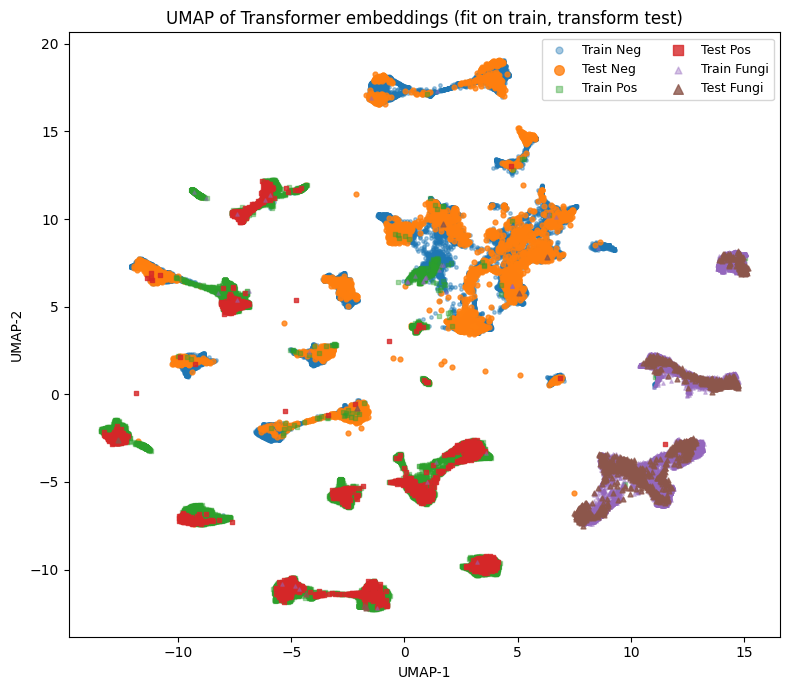

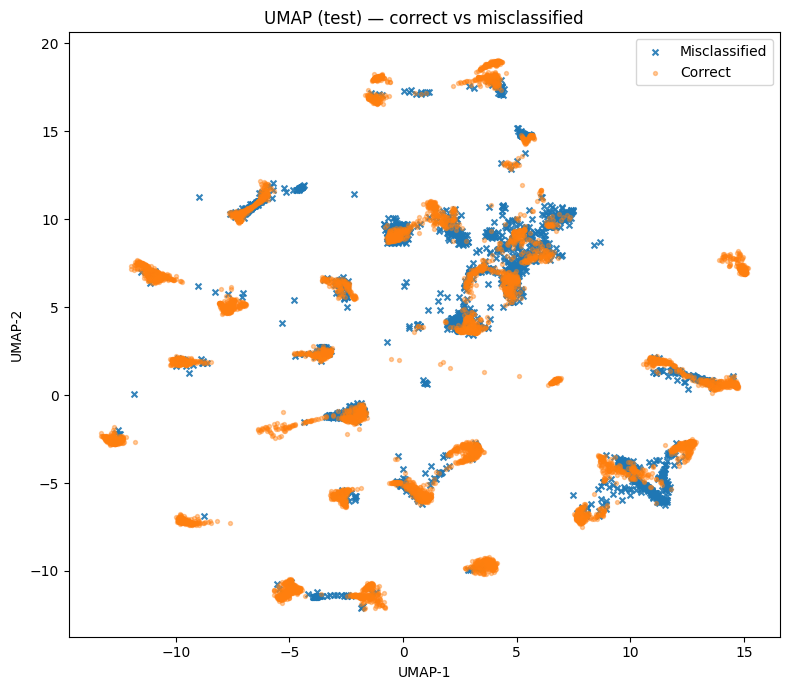


Worst 10 species by F1 on test:
species  support  precision   recall       f1
    Sma      300   0.177143 0.103333 0.130526
   CaAl      300   0.256098 0.210000 0.230769
    Lmo      300   0.972603 0.236667 0.380697
   CaTr      300   0.371901 0.450000 0.407240
    Cfr      300   0.651899 0.343333 0.449782
    Aba      300   0.623656 0.386667 0.477366
    Spn      300   0.644444 0.386667 0.483333
    Kox      300   0.663366 0.446667 0.533865
    Kpn      300   0.741176 0.420000 0.536170
    Eae      300   0.581994 0.603333 0.592471


In [7]:
# === Metrics (macro-F1) + UMAP embeddings (train→test) ===
# Uses your existing variables: model, device, train_loader, test_loader, unique_species, df

import sys, subprocess, math
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import f1_score, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 0) Try to import UMAP; install if missing
try:
    import umap
except Exception:
    print("Installing umap-learn...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "umap-learn"])
    import umap

# 1) Evaluate on TEST to get y_true / y_pred and macro-F1
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        y_true.extend(yb.numpy())
        y_pred.extend(preds)
y_true = np.array(y_true, dtype=int)
y_pred = np.array(y_pred, dtype=int)

macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
# Per-class metrics (aligned to your label order)
prec, rec, f1, sup = precision_recall_fscore_support(
    y_true, y_pred, labels=list(range(len(unique_species))), zero_division=0
)
per_class_df = pd.DataFrame({
    "species": unique_species,
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "support": sup
}).sort_values("f1", ascending=True).reset_index(drop=True)

print(f"\nMacro-F1 (test): {macro_f1:.3f}\n")
print("Classification report (truncated to 3 decimals):")
print(classification_report(
    y_true, y_pred,
    labels=list(range(len(unique_species))),
    target_names=unique_species,
    digits=3,
    zero_division=0
))

# 2) Helper: extract mean-pooled Transformer embeddings (pre-classifier)
def extract_embeddings(model, loader, device):
    model.eval()
    Z, y, yhat = [], [], []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device)
            # Recreate the forward pass up to pooling, using your module names
            x = Xb.unsqueeze(-1)                    # [B, L, 1]
            x = model.value_embedding(x)            # [B, L, d_model]
            x = x + model.pos_encoding[:, :x.size(1), :]  # add sinusoidal PE
            x = model.transformer_encoder(x)        # [B, L, d_model]
            h = x.mean(dim=1)                       # global average pool → [B, d_model]
            logits = model.classifier(h)            # for predicted labels
            Z.append(h.cpu().numpy())
            y.append(yb.numpy())
            yhat.append(logits.argmax(dim=1).cpu().numpy())
    return np.vstack(Z), np.concatenate(y), np.concatenate(yhat)

# 3) Build train/test embeddings
Ztr, ytr, yhat_tr = extract_embeddings(model, train_loader, device)
Zte, yte, yhat_te = extract_embeddings(model, test_loader, device)

# 4) UMAP: fit on TRAIN embeddings only, then transform TEST
scaler = StandardScaler().fit(Ztr)
Ztr_s = scaler.transform(Ztr)
Zte_s = scaler.transform(Zte)

U = umap.UMAP(n_neighbors=30, min_dist=0.1, metric='cosine', random_state=0)
U.fit(Ztr_s)
Utr = U.transform(Ztr_s)
Ute = U.transform(Zte_s)

# 5) Convenience: map species → group (Neg/Pos/Fungi) from your dataframe
species_group_map = df.drop_duplicates('ID').set_index('ID')['Group'].to_dict()
groups_tr = np.array([species_group_map[unique_species[i]] for i in ytr])
groups_te = np.array([species_group_map[unique_species[i]] for i in yte])

# 6) Plot 1: UMAP (train vs test) colored by Gram group
plt.figure(figsize=(8,7))
for grp, marker in [('Neg','o'), ('Pos','s'), ('Fungi','^')]:
    m_tr = groups_tr == grp
    m_te = groups_te == grp
    plt.scatter(Utr[m_tr,0], Utr[m_tr,1], s=6, alpha=0.4, label=f"Train {grp}", marker=marker)
    plt.scatter(Ute[m_te,0], Ute[m_te,1], s=12, alpha=0.8, label=f"Test {grp}", marker=marker)
plt.title("UMAP of Transformer embeddings (fit on train, transform test)")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.legend(markerscale=2, fontsize=9, ncol=2)
plt.tight_layout()
plt.show()

# 7) Plot 2: TEST only — correct vs misclassified (helps error analysis)
correct_te = (yte == yhat_te)
plt.figure(figsize=(8,7))
plt.scatter(Ute[~correct_te,0], Ute[~correct_te,1], s=18, alpha=0.9, label="Misclassified", marker='x')
plt.scatter(Ute[ correct_te,0], Ute[ correct_te,1], s=8,  alpha=0.4, label="Correct", marker='o')
plt.title("UMAP (test) — correct vs misclassified")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.legend()
plt.tight_layout()
plt.show()

# 8) Show the worst 10 classes by F1 (handy for your thesis table)
print("\nWorst 10 species by F1 on test:")
display_cols = ["species","support","precision","recall","f1"]
print(per_class_df[display_cols].head(10).to_string(index=False))


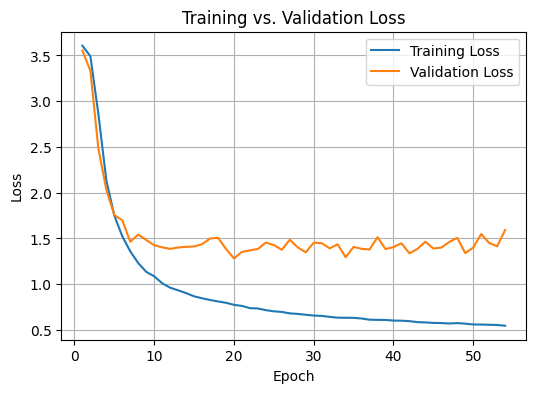

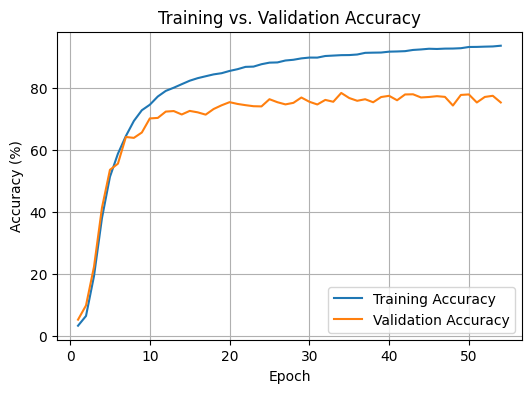

In [8]:
import matplotlib.pyplot as plt

epochs_ran = len(train_losses)  # total epochs that ran (could be less than num_epochs if early stopped)
epoch_range = range(1, epochs_ran+1)

# Plot Training and Validation Loss
plt.figure(figsize=(6,4))
plt.plot(epoch_range, train_losses, label='Training Loss')
plt.plot(epoch_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(6,4))
plt.plot(epoch_range, np.array(train_accuracies)*100, label='Training Accuracy')
plt.plot(epoch_range, np.array(val_accuracies)*100, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


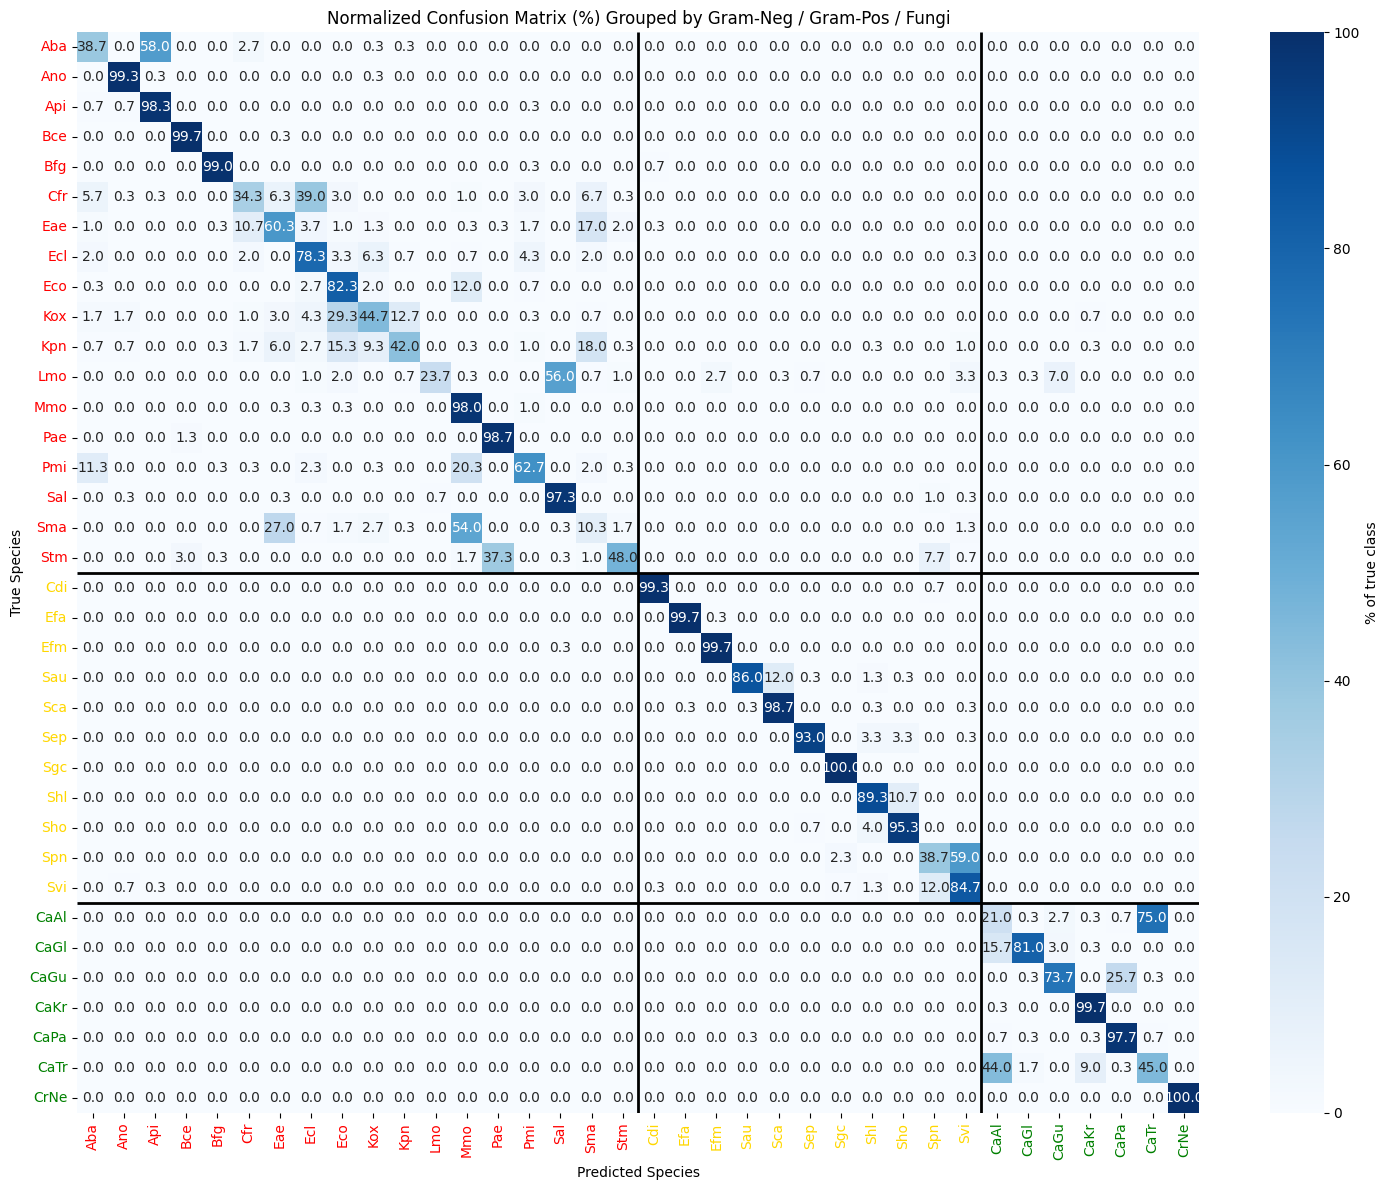

Test Accuracy: 75.50% (8154/10800)


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make sure model is in eval mode
model.eval()

# Collect true & predicted labels on the test set
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        # y_batch comes off the loader on CPU
        y_true.extend(y_batch.numpy())

y_true = np.array(y_true, dtype=int)
y_pred = np.array(y_pred, dtype=int)

# Build a species->group map
species_group_map = df.drop_duplicates('ID').set_index('ID')['Group'].to_dict()

# Order and colors
group_order  = ['Neg','Pos','Fungi']
group_colors = {'Neg':'red','Pos':'gold','Fungi':'green'}

# Create the ordered species list
species_ordered = [
    sp
    for grp in group_order
    for sp in unique_species
    if species_group_map[sp] == grp
]

# Compute and normalize the confusion matrix
cm_counts = confusion_matrix(y_true, y_pred, labels=np.arange(len(unique_species)))
row_sums  = cm_counts.sum(axis=1, keepdims=True)
cm_pct    = np.nan_to_num(cm_counts / row_sums * 100)  # fill 0/0 with 0

# Reorder rows & columns
idx       = [unique_species.index(sp) for sp in species_ordered]
cm_pct    = cm_pct[np.ix_(idx, idx)]

# Plot
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(
    cm_pct,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    xticklabels=species_ordered,
    yticklabels=species_ordered,
    cbar_kws={'label':'% of true class'},
    ax=ax
)

# Color tick labels by group
plt.xticks(rotation=90)
plt.yticks(rotation=0)
for lbl in ax.get_xticklabels():
    lbl.set_color(group_colors[species_group_map[lbl.get_text()]])
for lbl in ax.get_yticklabels():
    lbl.set_color(group_colors[species_group_map[lbl.get_text()]])

# Draw separators between Neg/Pos/Fungi blocks
neg_end = sum(1 for sp in species_ordered if species_group_map[sp]=='Neg')
pos_end = neg_end + sum(1 for sp in species_ordered if species_group_map[sp]=='Pos')
ax.hlines([neg_end, pos_end], *ax.get_xlim(), colors='black', linewidth=2)
ax.vlines([neg_end, pos_end], *ax.get_ylim(), colors='black', linewidth=2)

# Labels & title
ax.set_xlabel("Predicted Species")
ax.set_ylabel("True Species")
ax.set_title("Normalized Confusion Matrix (%) Grouped by Gram-Neg / Gram-Pos / Fungi")
plt.tight_layout()
plt.show()

# 2) Iterate over test set and accumulate correct / total
correct = 0
total   = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(X_batch)
        preds  = logits.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total   += y_batch.size(0)

# 3) Compute and print test accuracy
test_acc = correct / total * 100
print(f"Test Accuracy: {test_acc:.2f}% ({correct}/{total})")

<Figure size 520x520 with 0 Axes>

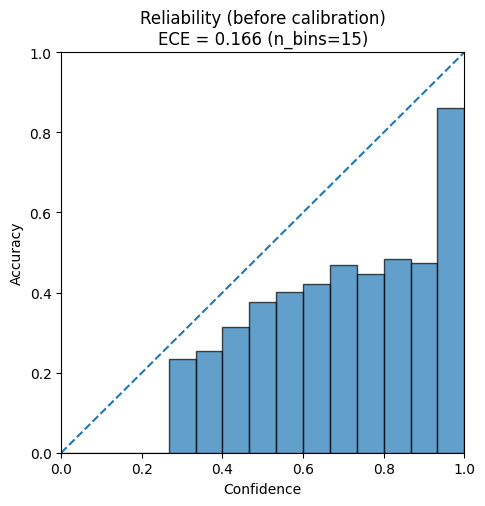

ECE (before): 0.166
Fitted temperature T = 1.151


<Figure size 520x520 with 0 Axes>

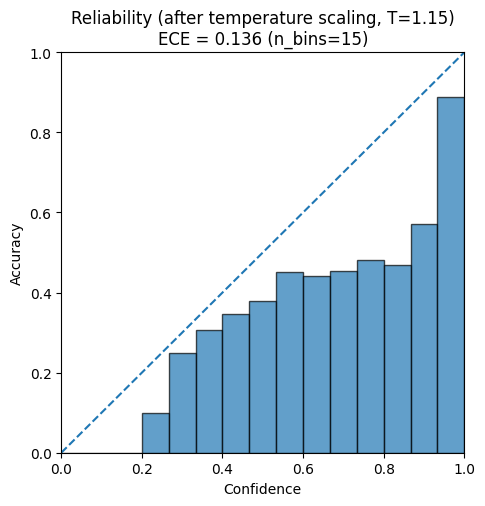

ECE (after): 0.136


In [10]:
# === Reliability diagram and ECE for multiclass (top-1) ===
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn, optim

@torch.no_grad()
def collect_logits_and_labels(model, loader, device):
    model.eval()
    logits_list, labels_list = [], []
    for X, y in loader:
        X = X.to(device)
        logits = model(X)          # [B, C]
        logits_list.append(logits.cpu())
        labels_list.append(y.cpu())
    logits = torch.cat(logits_list, dim=0).numpy()
    labels = torch.cat(labels_list, dim=0).numpy()
    return logits, labels

def softmax_np(z):
    z = z - z.max(axis=1, keepdims=True)
    exp = np.exp(z)
    return exp / exp.sum(axis=1, keepdims=True)

def reliability_and_ece(confidence, correct, n_bins=15, ax=None, title=""):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(confidence, bins) - 1
    accs, confs, counts = np.zeros(n_bins), np.zeros(n_bins), np.zeros(n_bins)
    for b in range(n_bins):
        m = bin_ids == b
        if m.any():
            accs[b]  = correct[m].mean()
            confs[b] = confidence[m].mean()
            counts[b]= m.sum()
    ece = np.sum((counts / counts.sum()) * np.abs(accs - confs))

    if ax is None:
        fig, ax = plt.subplots(figsize=(5.2, 5.2))
    width = bins[1] - bins[0]
    ax.bar(bins[:-1] + width/2, accs, width=width, alpha=0.7, edgecolor="k")
    ax.plot([0,1],[0,1], linestyle="--")
    ax.set_xlim(0,1); ax.set_ylim(0,1)
    ax.set_xlabel("Confidence"); ax.set_ylabel("Accuracy")
    ax.set_title(f"{title}\nECE = {ece:.3f} (n_bins={n_bins})")
    return ece

# 1) Collect logits
logits_val, y_val = collect_logits_and_labels(model, val_loader, device)
logits_test, y_test = collect_logits_and_labels(model, test_loader, device)

# 2) Before calibration
p_test = softmax_np(logits_test)
conf_test = p_test.max(axis=1)
pred_test = p_test.argmax(axis=1)
correct_test = (pred_test == y_test).astype(float)

plt.figure(figsize=(5.2,5.2))
ece_before = reliability_and_ece(conf_test, correct_test, n_bins=15, title="Reliability (before calibration)")
plt.show()
print(f"ECE (before): {ece_before:.3f}")

# 3) Temperature scaling fitted on VALIDATION
T = torch.ones(1, requires_grad=True)
z_val = torch.from_numpy(logits_val).float()
y_val_t = torch.from_numpy(y_val).long()
nll = nn.CrossEntropyLoss()
opt = optim.LBFGS([T], lr=0.01, max_iter=50)

def closure():
    opt.zero_grad()
    loss = nll(z_val / T, y_val_t)
    loss.backward()
    return loss

opt.step(closure)
T_value = float(T.detach().cpu().item())
print(f"Fitted temperature T = {T_value:.3f}")

# 4) After calibration (apply T to TEST logits)
p_test_cal = softmax_np(logits_test / T_value)
conf_cal = p_test_cal.max(axis=1)
pred_cal = p_test_cal.argmax(axis=1)
correct_cal = (pred_cal == y_test).astype(float)

plt.figure(figsize=(5.2,5.2))
ece_after = reliability_and_ece(conf_cal, correct_cal, n_bins=15, title=f"Reliability (after temperature scaling, T={T_value:.2f})")
plt.show()
print(f"ECE (after): {ece_after:.3f}")


In [11]:
# === Runtime & footprint measurement for the loaded model ===
import os, time, math, numpy as np, torch
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# 1) Parameter count and checkpoint size
def count_params(m):
    return sum(p.numel() for p in m.parameters())

n_params = count_params(model)
size_mb  = n_params * 4 / (1024**2)  # FP32
print(f"Parameters: {n_params:,}  (~{size_mb:.2f} MB FP32)")

ckpt_path = "checkpoints/best_model_by_macroF1.pt"
if os.path.exists(ckpt_path):
    ckpt_bytes = os.path.getsize(ckpt_path)
    print(f"Checkpoint file size: {ckpt_bytes/(1024**2):.2f} MB")
else:
    print("Checkpoint file not found (skip size).")

# 2) Build test loader (num_workers=0 for Windows/Jupyter)
batch1_loader = DataLoader(test_ds, batch_size=1,   shuffle=False, num_workers=0, pin_memory=True)
batchN_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=0, pin_memory=True)

# 3) Timing helpers
def _sync():
    if device.type == "cuda":
        torch.cuda.synchronize()

@torch.no_grad()
def measure_latency(loader, repeats=200, warmup=20):
    # iterate small batches from the loader
    times = []
    it = iter(loader)
    # warm-up
    for _ in range(warmup):
        try:
            xb, _ = next(it)
        except StopIteration:
            it = iter(loader); xb, _ = next(it)
        xb = xb.to(device, non_blocking=True)
        _sync(); _ = model(xb); _sync()
    # timed runs
    it = iter(loader); 
    for _ in range(repeats):
        try:
            xb, _ = next(it)
        except StopIteration:
            it = iter(loader); xb, _ = next(it)
        xb = xb.to(device, non_blocking=True)
        _sync(); t0 = time.time()
        _ = model(xb)
        _sync(); t1 = time.time()
        times.append((t1 - t0) / xb.size(0))  # per-sample time
    times = np.array(times)
    return times.mean()*1000, times.std()*1000  # ms/sample

lat1_ms_mean, lat1_ms_std = measure_latency(batch1_loader, repeats=200, warmup=20)
print(f"Latency (batch=1): {lat1_ms_mean:.2f} ± {lat1_ms_std:.2f} ms / spectrum")

# Throughput with batch=256 (report spectra/s)
@torch.no_grad()
def measure_throughput(loader, repeats=50, warmup=10):
    times = []
    it = iter(loader)
    # warm-up
    for _ in range(warmup):
        try:
            xb, _ = next(it)
        except StopIteration:
            it = iter(loader); xb, _ = next(it)
        xb = xb.to(device, non_blocking=True); _sync(); _ = model(xb); _sync()
    # timed runs
    it = iter(loader)
    for _ in range(repeats):
        try:
            xb, _ = next(it)
        except StopIteration:
            it = iter(loader); xb, _ = next(it)
        xb = xb.to(device, non_blocking=True)
        _sync(); t0 = time.time()
        _ = model(xb)
        _sync(); t1 = time.time()
        times.append(t1 - t0)
    times = np.array(times)
    bsz = loader.batch_size
    return (bsz / times.mean()), (bsz / times.std(ddof=1) if times.std() > 0 else float('nan'))

thr_sps_mean, _ = measure_throughput(batchN_loader, repeats=50, warmup=10)
print(f"Throughput (batch=256): {thr_sps_mean:.1f} spectra / second")

# 4) Optional: preprocessing cost (per spectrum)
# If your pipeline uses only in-memory min–max normalization, it is negligible.
# If you have baseline correction + SNV as numpy ops, you can measure similarly around that code.


Parameters: 797,988  (~3.04 MB FP32)
Checkpoint file size: 9.69 MB
Latency (batch=1): 1.41 ± 0.62 ms / spectrum
Throughput (batch=256): 2701.7 spectra / second


In [12]:
import torch, gc

# 2) Delete big objects
for name in ['model', 'optimizer', 'scheduler', 
             'train_loader', 'val_loader', 'test_loader',
             'train_ds', 'val_ds', 'test_ds']:
    if name in globals():
        del globals()[name]

# 3) Force garbage collection
gc.collect()

# 4) Empty PyTorch CUDA cache
torch.cuda.empty_cache()

print("Freed GPU memory; current allocated:", torch.cuda.memory_allocated(), 
      "cached:", torch.cuda.memory_reserved())


Freed GPU memory; current allocated: 21143552 cached: 553648128
